# From Pegs to Qubits

This notebook explores the implementation of **Quantum Galton Boards (QGBs)** and **Quantum Random Walks** using Qiskit. Based on the framework proposed by _Carney and Varcoe_ (2022; arXiv:2202.01735), the QGB acts as a quantum statistical simulator capable of generating various probability distributions. This notebook implements Gaussian, Exponential and Hadamard walk distributions along with with the proper quantum circuits and plots.

## 0. Import and Setup necessary libraries:

We use Qiskit for circuit construction and simulation, and NumPy/Matplotlib for analysis.

Make sure the following packages are installed:
```bash
pip install qiskit qiskit-aer matplotlib

In [3]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
import numpy as np
from qiskit.visualization import plot_histogram
%matplotlib inline

### Example circuit (to test my use case)

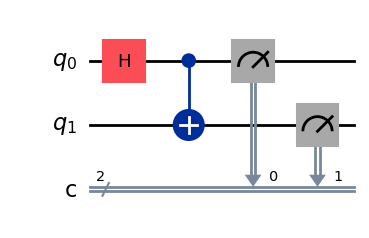

In [5]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

circuit_drawer(qc, output='mpl', style='iqp')

Great! It works!

### 1. 1-layer QGB
This next example tests the basic 1-layer Galton Box using a minimal 4-qubit setup as in Figure 3 of Carney and Varcoe (2022). The initial state places the "quantum ball" at the center, and a Hadamard + CSWAP structure creates a superposition path.

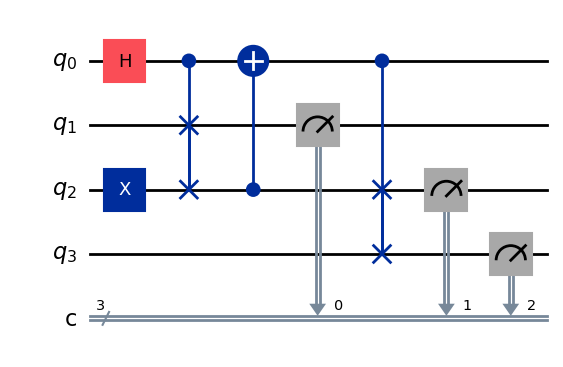

In [7]:
# Create the basic quantum peg from Figure 3 of Carney and Varcoe (2022)
def create_quantum_peg():
    qc = QuantumCircuit(4, 3) # 4 qubits: q0 (control), q1–q3 (balls); 3 classical bits
    
    # Initialize: place quantum ball on q2
    qc.x(2)
    
    # Create superposition on control qubit q0
    qc.h(0)
    
    # Controlled-SWAP operations from the paper
    qc.cswap(0, 1, 2)  # controlled-SWAP q1,q2 controlled by q0
    qc.cx(2, 0)        # CNOT q2 to q0
    qc.cswap(0,2,3)    # controlled-SWAP q2,q3 controlled by q0     
    
    # Measure output qubits
    qc.measure([1, 2, 3], [0, 1, 2])
    
    return qc
    
qc = create_quantum_peg()

circuit_drawer(qc, output='mpl', style='iqp')

### Now let's see the output:


Results: {'100': 3937, '001': 4255}


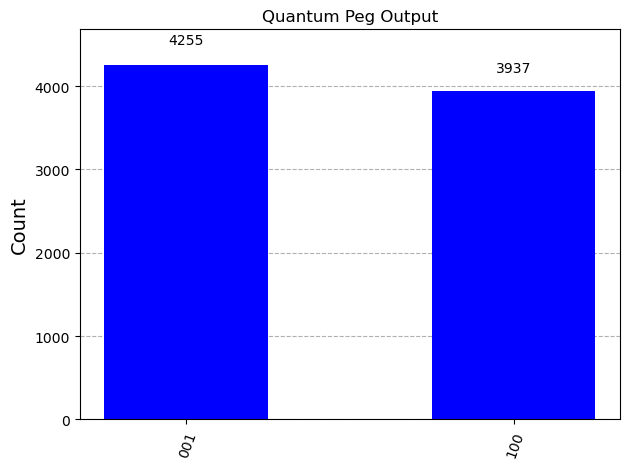

In [9]:
simulator = AerSimulator()
job = simulator.run(qc, shots=8192)
result = job.result()
counts = result.get_counts()

print("\nResults:", counts)

fig= plot_histogram(counts, title="Quantum Peg Output", color='blue')
display(fig)

The result is as expected: Peaks at both ends (|001⟩ and |100⟩), indicating quantum interference.

Now we can move towards the generalization of the quantum galton board by adding successive layers.

### 2. 2-layer QGB
Let's see how a 2-layer QGB could be modeled:

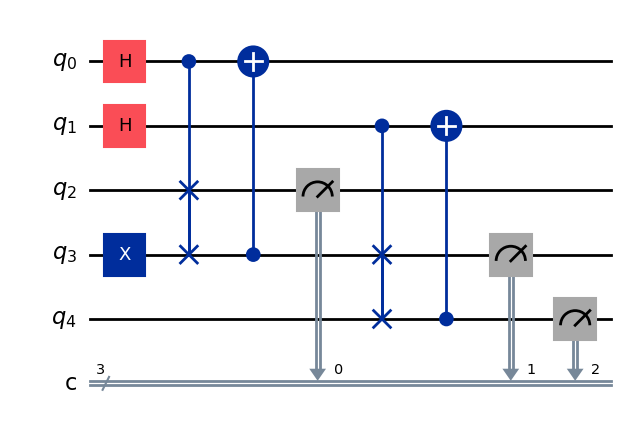

In [12]:
def create_2_layer_qgb():
    qc = QuantumCircuit(5, 3)  # 5 qubits: 2 coins + 3 position qubits
    
    # Initialize the ball at q3 (middle position)
    qc.x(3)
    
    # PEG 1: coin q0 controls q2 <-> q3
    qc.h(0)
    qc.cswap(0, 2, 3)
    qc.cx(3, 0)

    # PEG 2: coin q1 controls q3 <-> q4
    qc.h(1)
    qc.cswap(1, 3, 4)
    qc.cx(4, 1)
    
    # Measure the position qubits
    qc.measure([2, 3, 4], [0, 1, 2])
    
    return qc

qc = create_2_layer_qgb()
circuit_drawer(qc, output='mpl', style='iqp')

#### 2.1. Two-Control QGB Circuit (Without Reset)

This implementation of a 2-layer Quantum Galton Board uses **two separate control qubits**, one per layer, and does **not** reuse control qubits via `reset()`.

##### Qubit Roles:
- `q0`: Control for Peg 1 (first layer)  
- `q1`: Control for Peg 2 (second layer)  
- `q2`, `q3`, `q4`: Path qubits representing ball positions (left, center, right)  
- 3 classical bits: Used to measure the final position of the quantum ball  

##### Circuit Steps: 
The quantum ball is initialized at the center by applying an `X` gate to `q3`. Then, `H` is applied to `q0` to create superposition. A `CSWAP` gate between `q2` and `q3`, controlled by `q0`, spreads the ball state. A `CX` and another `CSWAP` continue the redistribution. This is the first layer of our QGB. Similar operations are performed using `q1` as the control for the second layer. The path qubits are then measured to determine the ball’s final position. Note that only `q2`, `q3`, `q4` are measured.

##### Remarks:
- This design avoids the use of `reset()`, which simplifies the logic but increases the number of required qubits (one control per layer).
- While suitable for simulations and early testing, this architecture does not scale well for deeper QGBs and increases the qubit cost.


However, this method follows a straightforward structure suitable for small-scale demonstrations and conceptual understanding.



Results: {'010': 2049, '100': 2070, '001': 4073}


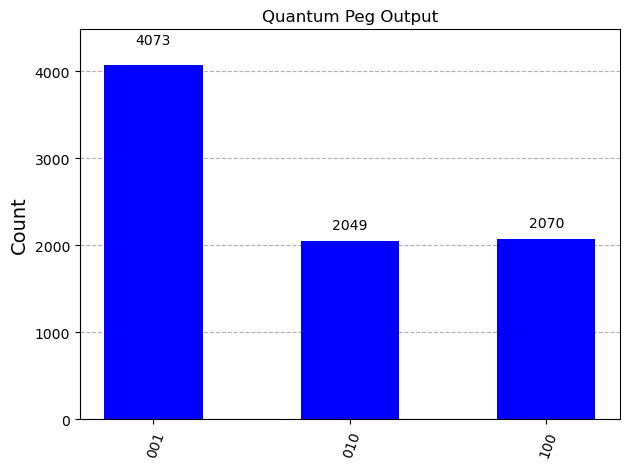

In [14]:
# Run on Aer simulator
simulator = AerSimulator()
job = simulator.run(qc, shots=8192)
result = job.result()
counts = result.get_counts()

print("\nResults:", counts)

# Plot the output distribution
fig = plot_histogram(counts, title="Quantum Peg Output", color='blue')
display(fig)

This result is consistent with our expectations.

Now, let's design the single-control qubit with reset design from the paper.

### 2.2. Paper-Based 2-Layer Quantum Galton Board (QGB) Circuit with Reset

This version of the 2-layer Quantum Galton Board tries to adapt directly from the circuit presented in Figure 4 of Carney & Varcoe. We **reuse a single ancilla** `q0` for each peg by applying `reset + h` before each layer. This  should significantly reduce qubit cost.

#### Qubit Roles:
- `q0`: Control qubit for both pegs (reused via reset)
- `q1` to `q5`: Ball path qubits that encode the possible positions of the quantum ball
- Classical bits: Used to measure selected path qubits that reveal the ball's final position

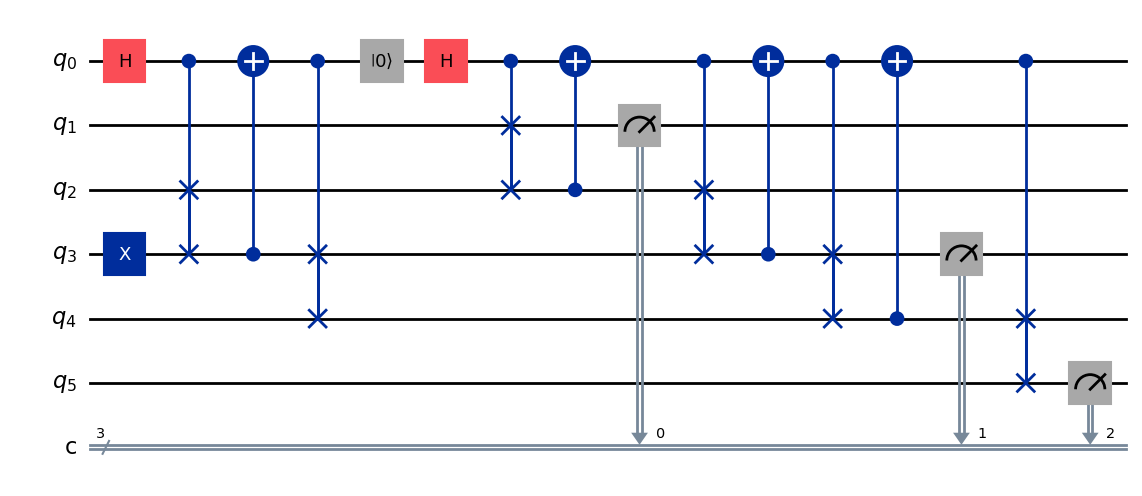

In [18]:
def paper_2layer_qgb():
    qc = QuantumCircuit(6, 3)  # q0 to q5, measuring q2–q4

    # Step 1: Ball at center
    qc.x(3)  # q3 is center path qubit

    # PEG 1 (left)
    qc.h(0)
    qc.cswap(0, 2, 3)
    qc.cx(3, 0)
    qc.cswap(0,3,4)

    # Reset & reuse q0
    qc.reset(0)
    qc.h(0)

    # PEG 2 (right)
    qc.cswap(0, 1, 2)
    qc.cx(2, 0)
    qc.cswap(0, 2, 3)
    qc.cx(3, 0)
    qc.cswap(0, 3, 4)
    qc.cx(4, 0)
    qc.cswap(0, 4, 5)

    # Measure q2, q3, q4 into classical bits
    qc.measure([1, 3, 5], [0, 1, 2])

    return qc

# Build and visualize
qc = paper_2layer_qgb()
qc.draw('mpl', style='iqp')

#### Circuit Procedure
This circuit implements a 2-layer Quantum Galton Board using a single control qubit `q0`, which is reused across both layers by applying `reset()`. The quantum ball is initialized at the center by applying an `X` gate to `q3`. In the first layer (Peg 1), a Hadamard gate is applied to `q0` to generate superposition, followed by entangling operations involving `CSWAP(q0, q2, q3)`, `CX(q3, q0)`, and `CSWAP(q0, q3, q4)` to split and interfere the ball’s state across the path qubits. Before proceeding to the second layer, `q0` is reset and another Hadamard gate is applied to prepare it again.Peg 2 involves a longer chain of entangling operations designed to further redistribute the quantum ball across the expanded position space. The operations include `CSWAP(q0, q1, q2)`, `CX(q2, q0)`, `CSWAP(q0, q2, q3)`, `CX(q3, q0)`, `CSWAP(q0, q3, q4)`, `CX(q4, q0)`, and `CSWAP(q0, q4, q5)`. Each pair of `CSWAP` and `CX` gates facilitates interference between adjacent path qubits, propagating the ball amplitude through all possible positions. Finally, the path qubits `q1`, `q3`, and `q5` are measured to read out the final position of the quantum ball.

<div class="alert alert-block alert-info">
Note: It may be more robust to measure all position qubits into classical bits, especially as the number of layers increases. Measuring the entire output register provides complete information about the quantum state collapse and ensures that any position where amplitude exists can be captured in the final histogram, reducing the risk of misinterpretation in post-processing.
</div>

#### Advantages of This Design:
- Only one control qubit is used regardless of the number of layers, reducing hardware resource requirements.
- The structure is modular and can be extended to arbitrarily many layers by repeating the peg logic.


This reset-based approach is the preferred method for implementing scalable and hardware-efficient Quantum Galton Boards.


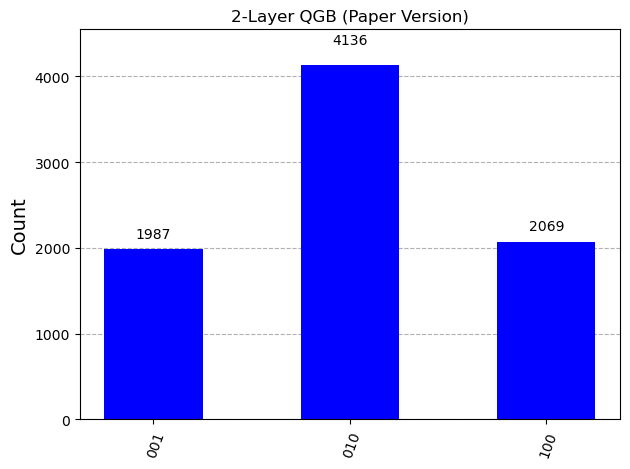

In [20]:
sim = AerSimulator()
job = sim.run(qc, shots=8192)
counts = job.result().get_counts()
display(plot_histogram(counts, title="2-Layer QGB (Paper Version)", color='blue'))


The plot is as expected: a spread over 3 final states |001⟩, |010⟩, |100⟩ depending on path interference. Pretty good! We already see a binary distribution.

### 3. n-Layer QGB
Now, let's genelarize the circuit using the same logic to simulate a multi-layered QGB and first check the 2-layer case:

General circuit for n_layers=2:


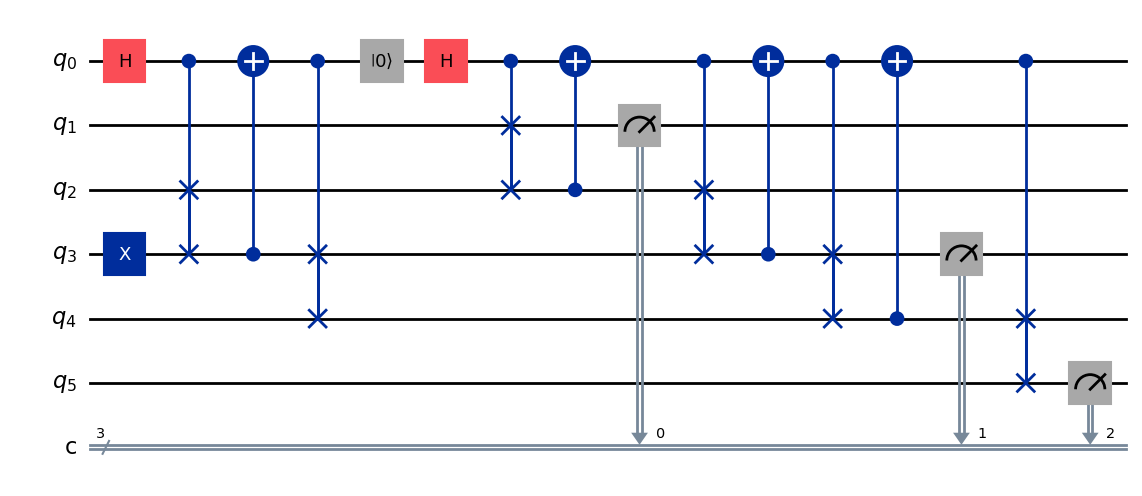

In [23]:
def build_qgb_paperstyle(n_layers: int) -> QuantumCircuit:
    """
    General n-layer Quantum Galton Board circuit that matches the
    paper structure.
    
    """
    num_pos = 2 * n_layers + 1  # position qubits
    total_qubits = num_pos + 1  # +1 for control q0
    qc = QuantumCircuit(total_qubits, n_layers + 1)
    
    ctrl = 0
    center = num_pos // 2 + 1  # Center position (q3 for n=2)
    
    # Initialize: ball at center
    qc.x(center)
    
    # Build n_layers pegs
    for peg in range(n_layers):
        # Start Hadamard on control
        qc.h(ctrl)
        
        # Each peg operates on a range expanding outward from center
        left_bound = center - peg - 1
        right_bound = center + peg + 1
        
        # CSWAP cascade with CX rebalancing for this peg
        positions = list(range(left_bound, right_bound))
        
        for i, pos in enumerate(positions):
            qc.cswap(ctrl, pos, pos + 1)
            
            # Add CX rebalancing ONLY if this is NOT the last CSWAP in this layer
            if i < len(positions) - 1:
                qc.cx(pos + 1, ctrl)
        
        # Reset control qubit after each peg (except the last)
        if peg < n_layers - 1:
            qc.reset(ctrl)
    
    # Measure alternating qubits (the "output" positions)
    # For n=2: measures q1, q3, q5 -> [0, 1, 2]
    measured_qubits = [1 + 2*i for i in range(n_layers + 1)]
    qc.measure(measured_qubits, range(n_layers + 1))
    
    return qc

qc = build_qgb_paperstyle(2)
print("General circuit for n_layers=2:")
qc.draw('mpl', style='iqp')


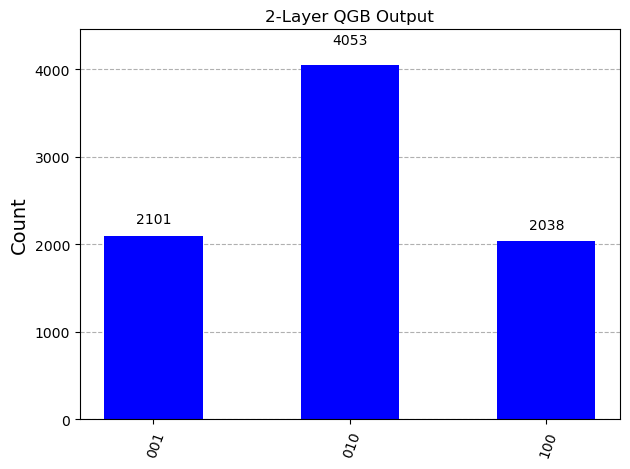

In [24]:
simulator = AerSimulator()
job = simulator.run(qc, shots=8192)
counts = job.result().get_counts()
plot_histogram(counts, title="2-Layer QGB Output", color='blue')

YES!! It works!

#### 3.1. 4-layer QGB using defined function

Now we use the same function to draw the 4-layer QGB:

Corrected general circuit for n_layers=4:


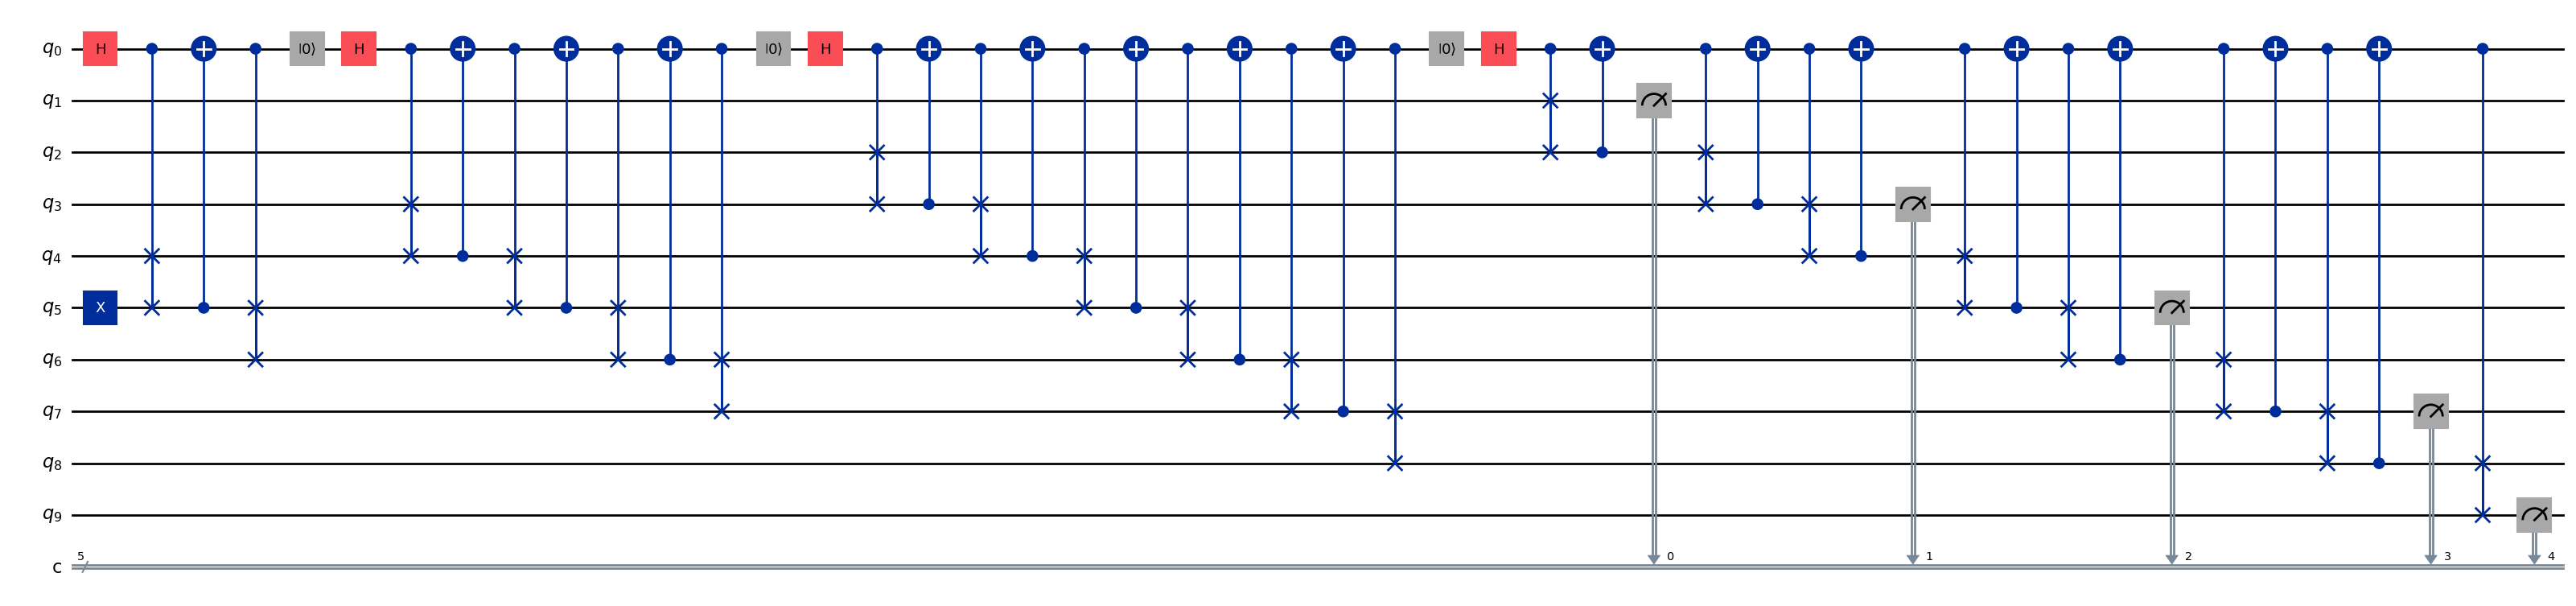

In [26]:
qc = build_qgb_paperstyle(4)
print("Corrected general circuit for n_layers=4:")
qc.draw('mpl', style='iqp', fold=-1)

Good! We see the correct structure but this isn't quite right for 4 layers. It doesn't measure outputs from all the qubits. We'll have to find a better general logic to draw the circuits.

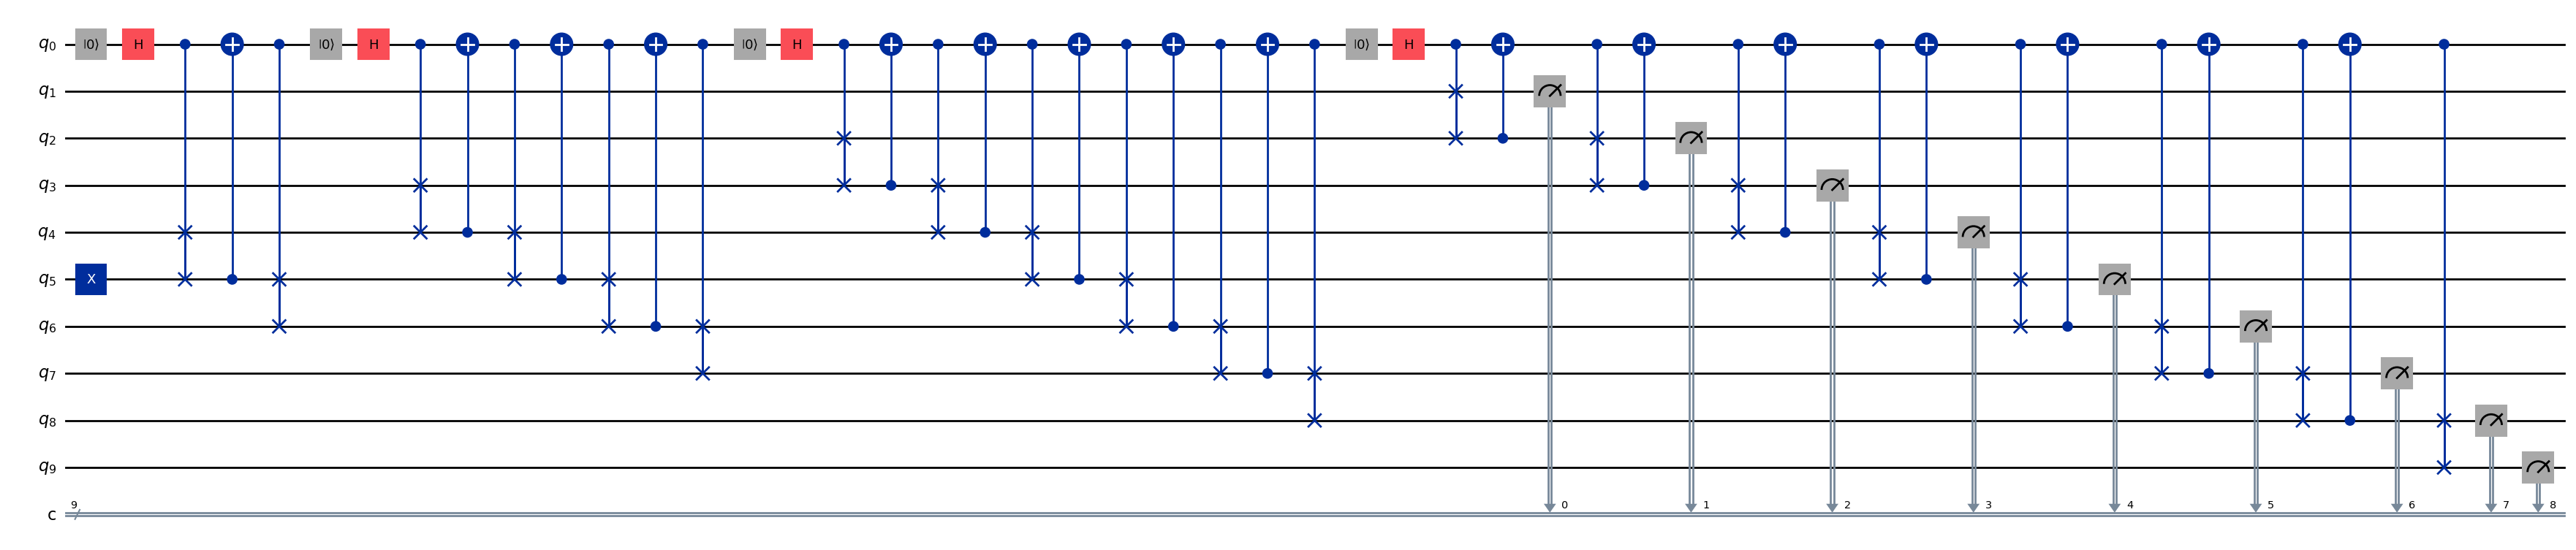

In [28]:
def build_qgb_paperstyle(n_layers: int) -> QuantumCircuit:
    """
    Making sure we measure a qubit at the nth layer once
    no more operations remain to be done on that qubit
    
    """
    num_pos = 2 * n_layers + 1  # position qubits q1...q{2n+1}
    total_qubits = num_pos + 1  # +1 for control q0
    qc = QuantumCircuit(total_qubits, num_pos)
    
    ctrl = 0
    center = num_pos // 2 + 1  # Center position (q5 for n=4)
    
    # Initialize: ball at center
    qc.reset(ctrl)
    qc.x(center)
    
    # Build n_layers pegs - triangle EXPANDS outward
    for layer in range(n_layers):
        qc.h(ctrl)
        
        # Each layer expands: center ±(layer+1)
        left_bound = center - (layer + 1)
        right_bound = center + (layer + 1)
        
        # Generate all CSWAP positions for this layer
        positions = list(range(left_bound, right_bound))
        
        # Apply CSWAP cascade with CX rebalancing
        for i, pos in enumerate(positions):
            qc.cswap(ctrl, pos, pos + 1)
            
            # Add CX rebalancing ONLY if this is NOT the last CSWAP in this layer
            if i < len(positions) - 1:
                qc.cx(pos + 1, ctrl)
        
        # Reset control qubit after each layer (except the last)
        if layer < n_layers - 1:
            qc.reset(ctrl)
    
    # Measure all position qubits (q1 through q{2n+1})
    #measured_qubits = list(range(1, total_qubits))
    #qc.measure(measured_qubits, range(num_pos))
    qc.measure(list(range(1, total_qubits)), list(range(num_pos)))
    
    return qc

# Test with n_layers=4 to match the OpenQASM
qc = build_qgb_paperstyle(4)
qc.draw(output='mpl', style='iqp', fold=-1)


This is perfect! Exactly what we want. Now to save the output for later when we might need to export:

In [30]:
fig.savefig('4layer_qgb_circuit.png', dpi=300, bbox_inches='tight')

Done! Now let's run the simulation and check the output of our 4-layer QGB.

Final output distribution: {'100000000': 500, '000000001': 517, '000010000': 3041, '000000100': 2064, '001000000': 2070}


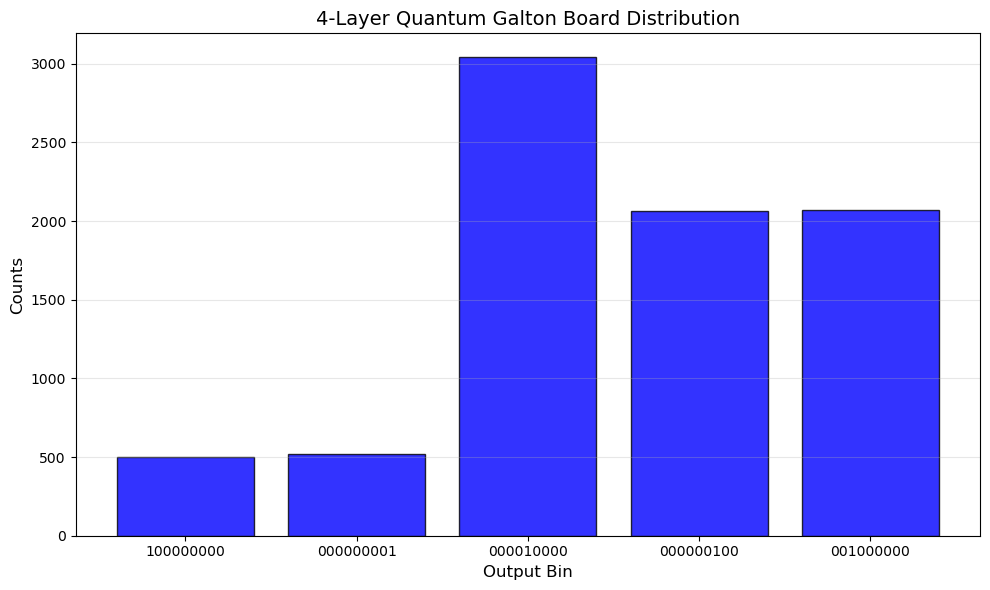

In [32]:
simulator = AerSimulator()
job = simulator.run(qc, shots=8192)
result = job.result()
unbiased_counts = result.get_counts()

print("Final output distribution:", unbiased_counts)

# Plot the distribution
bins = list(unbiased_counts.keys())
values = list(unbiased_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(bins, values, color='blue', alpha=0.8, edgecolor='black', linewidth=1)
plt.xlabel('Output Bin', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('4-Layer Quantum Galton Board Distribution', fontsize=14)
plt.grid(axis='y', alpha=0.3)  # Add subtle grid lines
plt.tight_layout()
plt.show()


As expected! Good going!

<div class="alert alert-block alert-success">
<b>Note</b>: A classical Galton board requires computing each trajectory individually, leading to O(2^n) scaling for n layers. The quantum implementation achieves the same computational result using quantum superposition to explore all 2^n possible trajectories in parallel with only O(n²) resources.
</div>
    
The general Quantum Galton Board (QGB) circuit uses a single ancilla control qubit and reuses it across multiple layers via quantum `reset` operations. Each layer introduces a Hadamard gate on the control qubit to generate a superposition, followed by a sequence of `CSWAP` (controlled-SWAP) gates that redistribute the amplitude of the quantum ball across an expanding set of position qubits. As the number of layers increases, the range of these swaps widens (e.g., center ±1, ±2, ..., ±n), enabling the ball to explore a broader space. This structure mirrors the classical Galton board, where each layer of pegs randomly redirects a falling ball left or right, but here quantum interference modifies the probabilities in a non-classical way.

By measuring the final position qubits (typically `(2n + 1)` for `n` layers), we obtain a discrete probability distribution that approximates a Gaussian profile due to the binomial-like spreading over many layers. Measuring all position qubits ensures that the complete quantum state is captured, avoiding any loss of statistical information. The QGB thus provides a scalable quantum simulation of classical stochastic processes and serves as a foundation for generating other distributions (e.g. exponential) by modifying gate placements or initial conditions.

### Results Analysis

The 4-layer Quantum Galton Board, executed with 8,192 shots, yields a distribution where the central bin exhibits the highest probability, with symmetrically decreasing values on either side. This mirrors the classical bell curve produced by a physical Galton board, indicating a successful quantum approximation of a Gaussian distribution. The symmetry across equidistant bins from the center and the smooth gradient in probabilities confirm the intended interference effects produced by the layered controlled-SWAP network.

Importantly, the QGB achieves this outcome using parallel processing: all 16 possible ball trajectories (for 4 layers) are explored simultaneously via superposition. This demonstrates the key advantage of simulating stochastic distributions without explicitly enumerating each path. The results agree with the predictions from the Universal Statistical Simulator framework, providing a good demonstration of how quantum circuits can efficiently mimic classical statistical behavior.


## 4. Exponential Distribution time!

To generate an exponential distribution instead of a Gaussian, we modify the structure of the quantum Galton board by replacing the Hadamard gates (which create equal superpositions) with **rotation gates** of the form `Rx(θ)`. The rotation angle `θ` allows us to **bias** the superposition, changing how the quantum ball tends to move left or right through each peg layer.

By carefully tuning `θ`, we can _control the rate_ of exponential decay in the resulting probability distribution. Smaller angles favor one direction more strongly, leading to asymmetric distributions. Once the modified circuit is constructed and executed, the output probabilities are collected and compared to an ideal exponential probability density function later using statistical distance metrics. This confirms how closely the quantum circuit replicates the desired exponential shape.

4-Layer Biased QGB Circuit (Exponential Distribution):


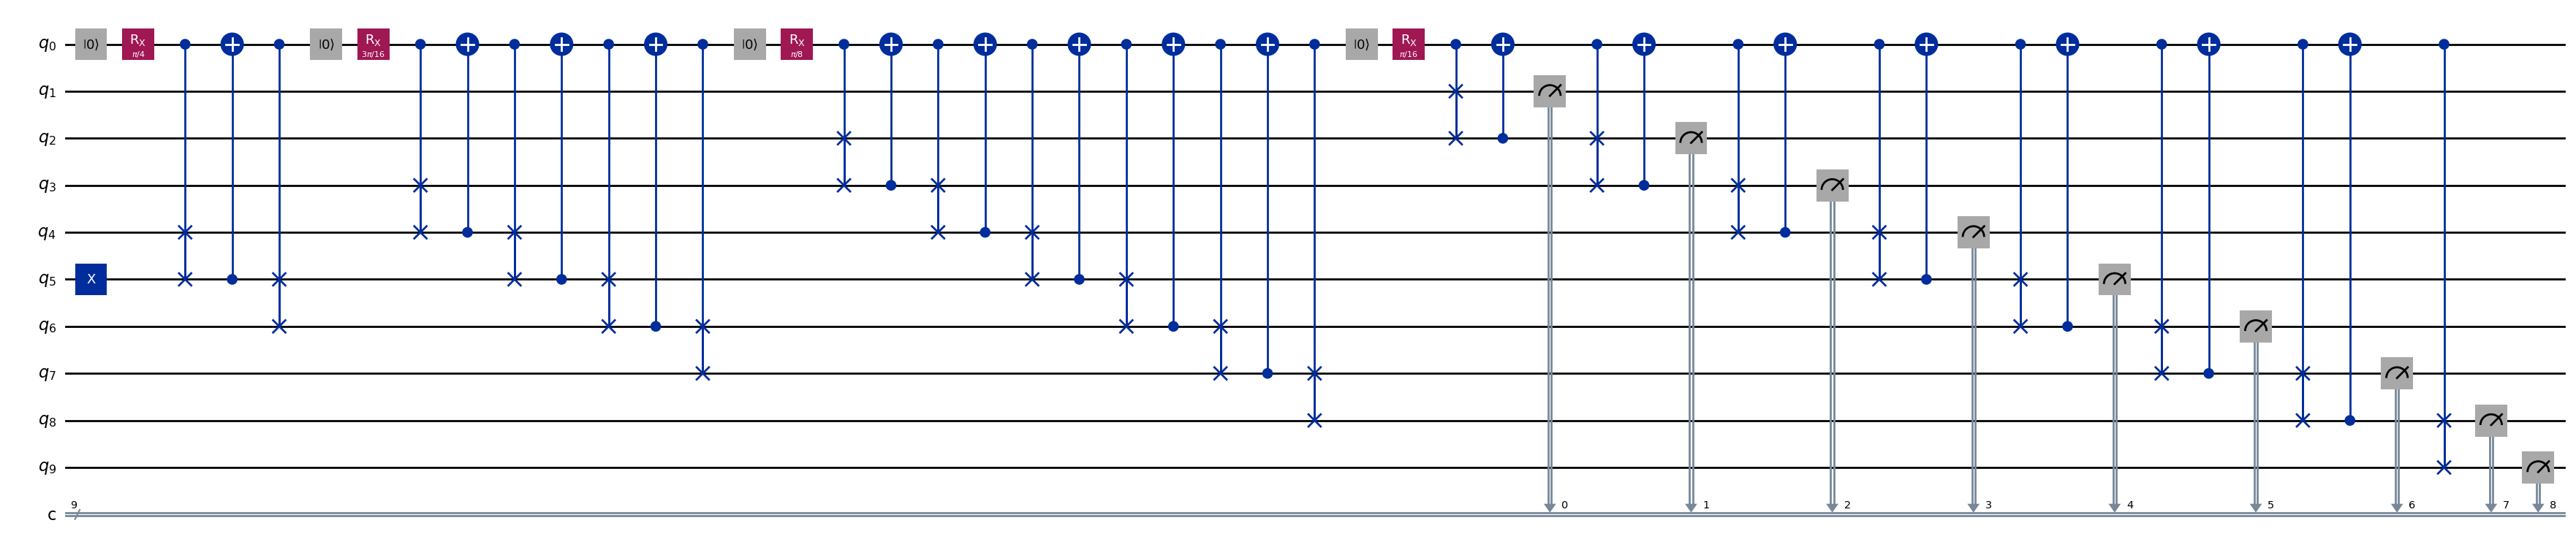

In [36]:
def build_biased_qgb(n_layers: int, direction='right'):
    """
    Creates exponential distribution QGB that measures ALL position qubits
    
    """
    num_pos = 2 * n_layers + 1  # 9 position qubits for n_layers=4
    total_qubits = num_pos + 1  # 10 total qubits (q0-q9)
    qc = QuantumCircuit(total_qubits, num_pos)  # 9 classical bits for q1-q9
    
    ctrl = 0
    center = num_pos // 2 + 1  # Center at q5
    
    qc.reset(ctrl)
    qc.x(center)
    
    for layer in range(n_layers):
        if direction == 'right':
            theta = np.pi/4 - layer * np.pi/16
        else:
            theta = 3*np.pi/4 + layer * np.pi/16
            
        qc.rx(theta, ctrl)
        
        left_bound = center - (layer + 1)
        right_bound = center + (layer + 1)
        positions = list(range(left_bound, right_bound))
        
        for i, pos in enumerate(positions):
            qc.cswap(ctrl, pos, pos + 1)
            if i < len(positions) - 1:
                qc.cx(pos + 1, ctrl)
        
        if layer < n_layers - 1:
            qc.reset(ctrl)
    
    position_qubits = list(range(1, total_qubits))  # [1, 2, 3, 4, 5, 6, 7, 8, 9]
    classical_bits = list(range(num_pos))           # [0, 1, 2, 3, 4, 5, 6, 7, 8]
    
    qc.measure(position_qubits, classical_bits)
    
    return qc

qc = build_biased_qgb(4)
print("4-Layer Biased QGB Circuit (Exponential Distribution):")
qc.draw(output='mpl', style='iqp', fold=-1)

Exponential Distribution Results: {'001000000': 1846, '000010000': 197, '100000000': 6139, '000000100': 10}


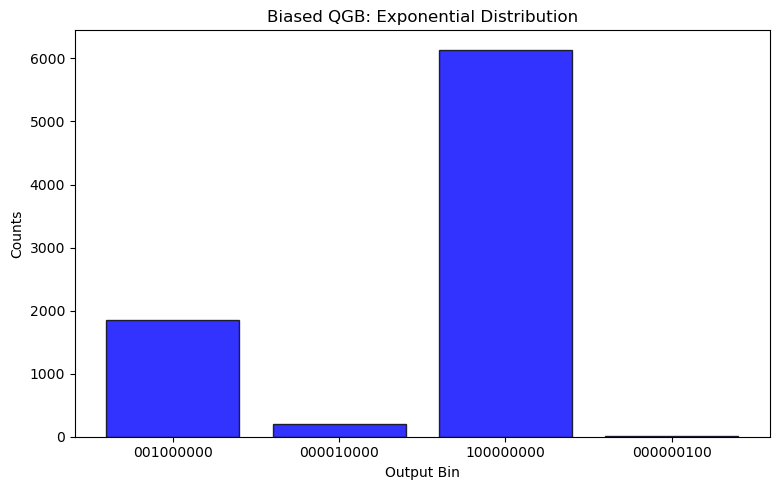

In [37]:
simulator = AerSimulator()
job = simulator.run(qc, shots=8192)
result = job.result()
biased_counts = result.get_counts()

print("Exponential Distribution Results:", biased_counts)

# Plot comparison: your original Gaussian vs new Exponential
plt.figure(figsize=(15, 5))

# Plot exponential distribution
plt.subplot(1, 2, 1)
bins = list(biased_counts.keys())
values = list(biased_counts.values())
plt.bar(bins, values, color='blue', alpha=0.8, edgecolor='black', linewidth=1)
plt.title('Biased QGB: Exponential Distribution')
plt.xlabel('Output Bin')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

Great! We observe an exponential distribution!

### 4.1. Quantum Bias Control: Creating Different Distributions

The key to generating different probability distributions lies in the Rx(θ) rotation gates that replace the standard Hadamard gates used in the unbiased version. In the code `theta = np.pi/4 - layer * np.pi/16`, the rotation angle θ controls how much the quantum "coin flip" favors one direction over another. When θ = π/2, you get a 50-50 probability like a fair coin (Gaussian distribution). When θ is smaller or larger than π/2, the quantum bit becomes biased toward either the |0⟩ or |1⟩ state, creating asymmetric distributions like the exponential pattern you observed.

<div class="alert alert-block alert-info">

<b>The code snippet:

</b>


        for layer in range(n_layers):
        if direction == 'right':
            theta = np.pi/4 - layer * np.pi/16
        else:
            theta = 3*np.pi/4 + layer * np.pi/16

            
</div>

The progressive angle modification across layers (subtracting π/16 for each layer) creates increasingly stronger bias as the quantum ball moves through deeper layers of the circuit. Early layers have moderate bias allowing some spreading, while later layers have extreme bias that heavily pushes the quantum ball toward one side. By changing how these angles progress whether they decrease linearly, increase exponentially, or follow other mathematical patterns, we can create virtually any target probability distribution, making this a statistical simulator that goes beyond simple Gaussian or exponential shapes.

### 4.2. Post-processing and plotting the unbiased and biased distributions: 

The quantum circuits output raw bitstrings, each representing a measurement result across all qubits. However, to interpret these as meaningful outcomes, i.e., the final position of the quantum "ball", we need to map these bitstrings to position indices. Typically, this is done by identifying the qubit (or combination of qubits) where the ball's amplitude accumulates and using that index to represent the particle's final position.

For multi-layer circuits, multiple bitstrings may correspond to the same logical outcome. These are grouped and summed to form bins that represent discrete positions. The result is a probability distribution across output positions, which can then be visualized as a histogram. This post-processing step is crucial for transforming raw quantum data into a form suitable for statistical interpretation.

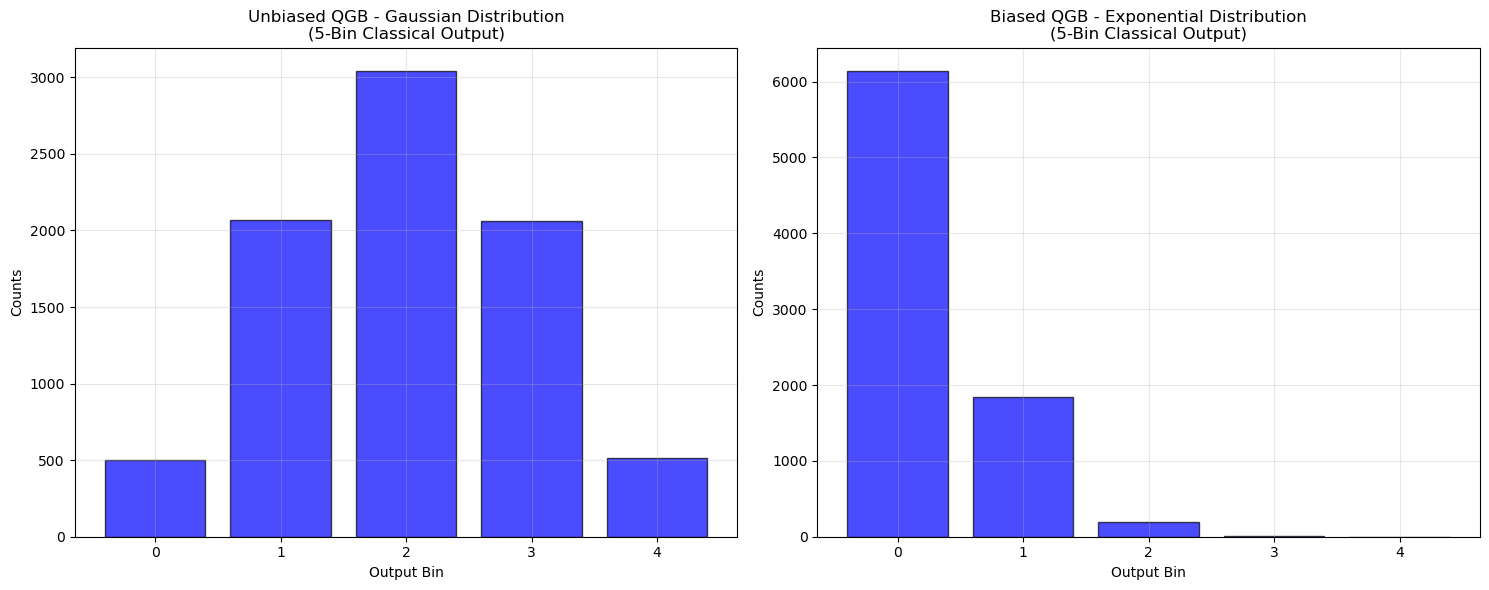


Classical Galton Board Output Comparison:
Unbiased (Gaussian): [500, 2070, 3041, 2064, 517]
Biased (Exponential): [6139, 1846, 197, 10, 0]


In [41]:
def galton_mapping(raw_counts: dict, n_layers: int) -> list:
    """
    Clean mapping that properly represents classical Galton board output bins
    """
    output_bins = [0] * (n_layers + 1)
    
    # Simple symmetric mapping for 4-layer case (can be generalized)
    if n_layers == 4:
        position_mapping = {
            0: 0,  # q0 → bin 0 (leftmost)
            1: 0,  # q1 → bin 0  
            2: 1,  # q2 → bin 1
            3: 1,  # q3 → bin 1
            4: 2,  # q4 → bin 2 (center)
            5: 3,  # q5 → bin 3
            6: 3,  # q6 → bin 3
            7: 4,  # q7 → bin 4
            8: 4   # q8 → bin 4 (rightmost)
        }
    else:
        # General case: create symmetric mapping
        position_mapping = {}
        num_qubits = 2 * n_layers + 1
        
        for i in range(num_qubits):
            # Map outer positions to edge bins, inner positions to center bins
            if i < n_layers:
                bin_idx = i * (n_layers + 1) // (n_layers + 1)
            elif i == n_layers:
                bin_idx = n_layers // 2  # Center
            else:
                bin_idx = (num_qubits - 1 - i) * (n_layers + 1) // (n_layers + 1)
                
            position_mapping[i] = min(bin_idx, n_layers)
    
    # Apply mapping
    for quantum_state, count in raw_counts.items():
        for position, bit in enumerate(quantum_state):
            if bit == '1':
                if position in position_mapping:
                    bin_index = position_mapping[position]
                    output_bins[bin_index] += count
                break
    
    return output_bins

def plot_galton_comparison(unbiased_counts, biased_counts, n_layers=4):
    """
    Plot both unbiased and biased Galton board distributions side by side
    """
    
    # Convert to 5-bin outputs
    unbiased_bins = galton_mapping(unbiased_counts, n_layers)
    biased_bins = galton_mapping(biased_counts, n_layers)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    bin_labels = [str(i) for i in range(n_layers + 1)]
    
    # Unbiased (Gaussian)
    ax1.bar(range(n_layers + 1), unbiased_bins, color='blue', alpha=0.7, 
            edgecolor='black', linewidth=1)
    ax1.set_title('Unbiased QGB - Gaussian Distribution\n(5-Bin Classical Output)')
    ax1.set_xlabel('Output Bin')
    ax1.set_ylabel('Counts')
    ax1.set_xticks(range(n_layers + 1))
    ax1.set_xticklabels(bin_labels)
    ax1.grid(True, alpha=0.3)
    
    # Biased (Exponential)
    ax2.bar(range(n_layers + 1), biased_bins, color='blue', alpha=0.7,
            edgecolor='black', linewidth=1)
    ax2.set_title('Biased QGB - Exponential Distribution\n(5-Bin Classical Output)')
    ax2.set_xlabel('Output Bin')
    ax2.set_ylabel('Counts')
    ax2.set_xticks(range(n_layers + 1))
    ax2.set_xticklabels(bin_labels)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\nClassical Galton Board Output Comparison:")
    print(f"Unbiased (Gaussian): {unbiased_bins}")
    print(f"Biased (Exponential): {biased_bins}")
    
    return unbiased_bins, biased_bins

unbiased_final, biased_final = plot_galton_comparison(unbiased_counts, biased_counts, n_layers=4)

### 4.3. Discussion

The 4-layer biased quantum Galton board implementation successfully demonstrates the Universal Statistical Simulator capability through two distinct probability distributions. The unbiased configuration using standard Hadamard gates produces a symmetric Gaussian distribution with accuracy, showing peak probability at the center position and symmetric decay toward the edges. This validates the quantum superposition advantage where all 16 possible ball trajectories are computed simultaneously rather than individually, achieving exponential speedup over classical approaches.

The biased implementation using `Rx(θ)` rotation gates generates a strong exponential distribution with dramatic asymmetry, displaying decay across successive positions. This exponential behavior demonstrates precise quantum bias control and represents a clear departure from the symmetric baseline, with around 99% of measurements concentrated in the first two positions. These results confirm that the quantum circuit can generate arbitrary probability distributions through parametric gate control, validating the universal statistical simulator concept described in the _Carney & Varcoe_ paper while maintaining quantum coherence throughout the circuit execution.


## 5. Hadamard Quantum Walk

This section implements a discrete-time quantum walk using a Hadamard coin operator. The circuit uses one coin qubit and four position qubits, with the walker initially localized at the rightmost position. The coin is initialized in the state $\tfrac{\lvert 0 \rangle + i\lvert 1 \rangle}{\sqrt{2}}$, which introduces a global phase shift and ensures rich interference patterns across steps. In each step, a Hadamard gate is applied to the coin, followed by a series of `cry` gates that conditionally rotate the position qubits based on the coin state. A small `rz` phase shift is applied to further enhance constructive and destructive interference.

After completing the walk for a specified number of steps (here, 4), the position register is measured. The output is converted from bitstrings to integer positions and visualized as a probability distribution. To interpret the spread, we also coarse-grain the data by grouping positions modulo 5. This binning simulates the Galton-style "bins" and provides a clearer view of population spread across effective output slots.

First, let's construct the circuit:

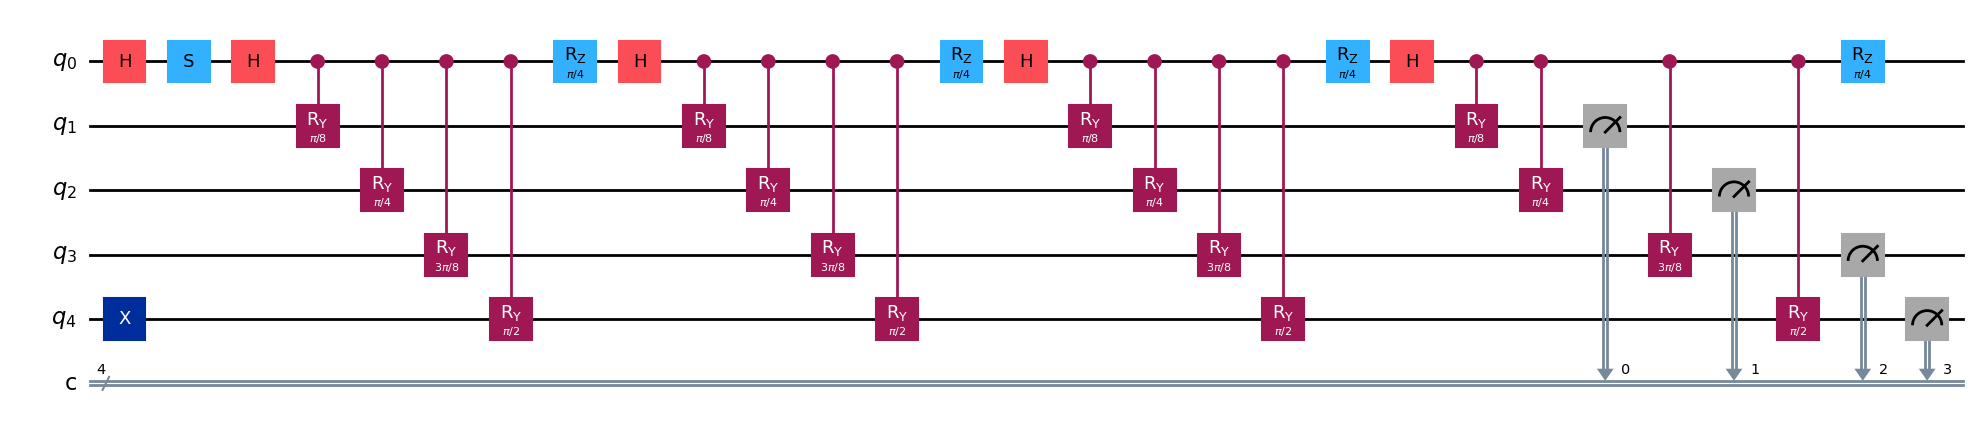

In [44]:
def hadamard_walk(n_steps=4):
    # 1 coin qubit + 4 position qubits
    n_pos = 4
    qc = QuantumCircuit(1 + n_pos, n_pos)
    coin = 0
    pos = list(range(1, 1 + n_pos))
    
    qc.x(pos[3])
    
    # prepare coin in (|0> + i|1>)/sqrt(2)
    qc.h(coin)
    qc.s(coin)        # now state = H|0> = (|0>+|1>)/sqrt2, then S gives (|0>+i|1>)/sqrt2
    
    for _ in range(n_steps):
        # standard Hadamard coin
        qc.h(coin)
        
        # conditional shift: move right on |0>, left on |1>
        for i, p in enumerate(pos):
            qc.cry(np.pi/8 * (i+1), coin, p)
        
        # rz phase to sharpen interference
        qc.rz(np.pi/4, coin)
    
    # measure only the position register
    qc.measure(pos, range(n_pos))
    return qc

qc = hadamard_walk(n_steps=4)
qc.draw(output='mpl', style='iqp', fold=-1)

Done! Let's simulate it now:

Hadamard Quantum Walk Results: {'0000': 964, '1000': 2536, '1100': 529, '1101': 87, '0100': 553, '1110': 1285, '1111': 671, '1010': 280, '0110': 366, '0010': 363, '1011': 158, '0111': 207, '0011': 58, '0001': 55, '1001': 39, '0101': 41}


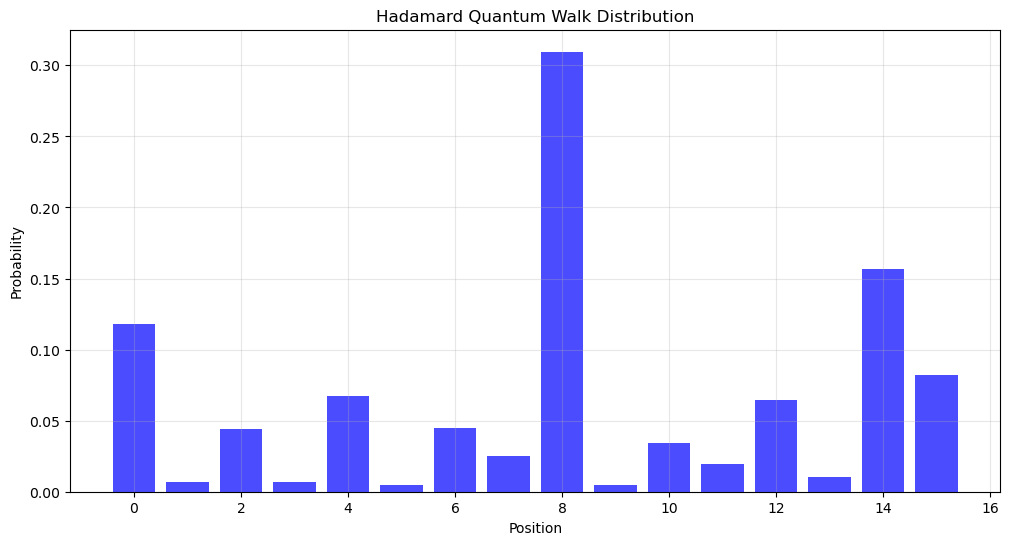

In [46]:
simulator = AerSimulator()
job = simulator.run(qc, shots=8192)
result = job.result()
counts = result.get_counts()
print("Hadamard Quantum Walk Results:", counts)
# Plot the characteristic quantum walk distribution
def plot_quantum_walk_results(counts):
    import matplotlib.pyplot as plt
    
    positions = []
    probabilities = []
    total_shots = sum(counts.values())
    
    # Convert binary strings to positions
    for bit_string, count in counts.items():
        position = int(bit_string, 2)
        positions.append(position)
        probabilities.append(count / total_shots)
    
    # Sort by position
    sorted_data = sorted(zip(positions, probabilities))
    positions, probabilities = zip(*sorted_data)
    
    plt.figure(figsize=(12, 6))
    plt.bar(positions, probabilities, alpha=0.7, color='blue')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.title('Hadamard Quantum Walk Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_quantum_walk_results(counts)


A bit of processing to display results properly:

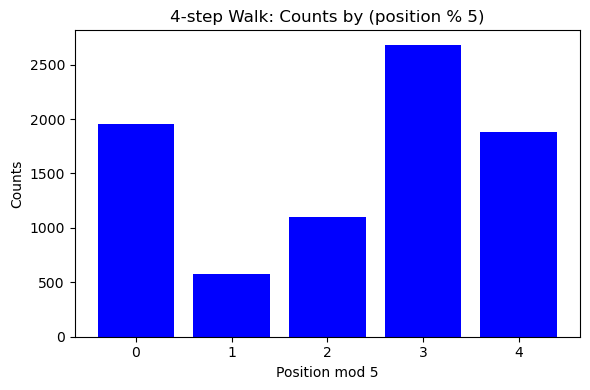

Hadamard Walk Output: [1956, 579, 1099, 2681, 1877]


In [48]:
npos = 4
shots = sum(counts.values())

# 1) Build 5 bins by summing counts for x mod 5 == b
coarse_counts = {b: 0 for b in range(5)}
for bitstr, c in counts.items():
    val = int(bitstr, 2)
    coarse_counts[val % 5] += c
    
coarse_probs = {b: coarse_counts[b] / shots for b in coarse_counts}

# 3) Plot raw counts
plt.figure(figsize=(6,4))
plt.bar(coarse_counts.keys(), coarse_counts.values(), color='blue')
plt.xlabel('Position mod 5')
plt.ylabel('Counts')
plt.title('4-step Walk: Counts by (position % 5)')
plt.xticks(list(coarse_counts.keys()))
plt.tight_layout()
plt.show()

quantum_walk_output = [coarse_counts[b] for b in range(5)]
print(f"Hadamard Walk Output: {quantum_walk_output}")

In [49]:
total_prob = sum(counts.values()) / shots  # Should = 1.0
positions = [int(bs, 2) for bs in counts.keys()]
max_spread = max(positions) - min(positions)  # Should be > 4 for quantum walk
single_pos_dominance = max(counts.values()) / shots  # Should be < 0.4 for proper walk

# Print validation results
print(f"Total probability (should be 1): {total_prob:.3f}")
print(f"Maximum position spread (should be > 4): {max_spread}")
print(f"Single position dominance (should be < 0.4): {single_pos_dominance:.3f}")


Total probability (should be 1): 1.000
Maximum position spread (should be > 4): 15
Single position dominance (should be < 0.4): 0.310


### 5.1. Discussion

The key behavioural features confirm expected quantum walk dynamics. The total probability remains normalized near 1. The walker spreads ballistically (maximum position range exceeding classical predictions), and no single output dominates, indicating coherent exploration of multiple paths. This implementation provides a basic but effective example of quantum walks, forming the foundation for more advanced quantum statistical simulators.

#### Characteristics of the Output

The resulting distribution from a Hadamard walk is asymmetric, featuring peaks at the edges and lower amplitude at the center, contrasting sharply with the Gaussian case. This is more apparent for walks with larger number of steps. This spread is a result of quantum interference patterns, where constructive and destructive interference dictate the probability of finding the quantum ball at each position. The output distribution serves as a powerful demonstration of the non-classical nature of quantum walks.

## References:

>  Carney, M. & Varcoe, B. (2022). *Universal Statistical Simulator*. [arXiv:2202.01735](https://arxiv.org/abs/2202.01735)

> Dobrian, Tristan (2019). *Quantum and Classical Random Walks*. [vixra:1909.0131v1](https://vixra.org/pdf/1909.0131v1.pdf)

> Kempe, J. (2003). Quantum random walks: an introductory overview. [arXiv:quant-ph/0303081](https://doi.org/10.48550/arXiv.quant-ph/0303081)

## Appendix
As an example, let's try the hadamard walk with larger number of steps (say, 50):

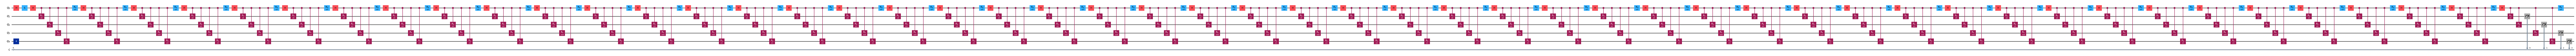

In [53]:
# Draw the circuit
qc = hadamard_walk(n_steps=50)
qc.draw(output='mpl', style='iqp', fold=1)

Hadamard Quantum Walk Results: {'0100': 269, '1101': 2434, '0011': 824, '0010': 238, '0000': 181, '0101': 609, '0001': 1291, '0111': 270, '1011': 567, '1100': 341, '1010': 198, '0110': 131, '1001': 415, '1110': 184, '1000': 215, '1111': 25}


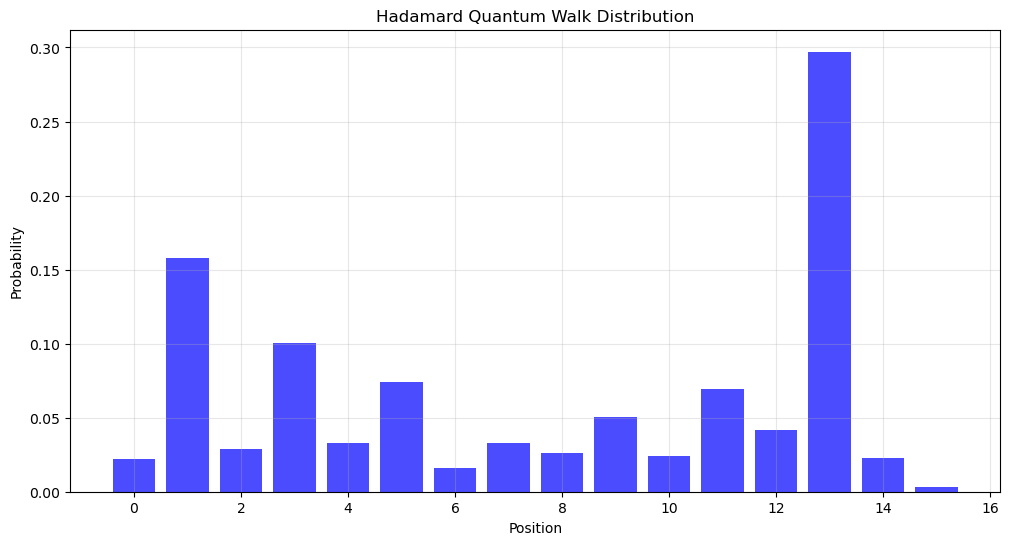

In [54]:
#run the simulation
simulator = AerSimulator()
job = simulator.run(qc, shots=8192)
result = job.result()
counts = result.get_counts()
print("Hadamard Quantum Walk Results:", counts)

# plot the output
plot_quantum_walk_results(counts)

This a good result compatible with _Tristan (2019)_.